In [1]:
import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 

#Import for obtaining class activation heatmaps
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.optimizer import Optimizer
from vis.callbacks import GifGenerator
from vis.visualization import visualize_cam

#Linear Algebra and sklearn stuff
import numpy as np
import pandas
import matplotlib.pyplot as plt
import numpy
from PIL import Image

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, ball
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

"""
Thanks to Sebastian Otalora for part of the code on the average nuclei regression
"""

/home/mara/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
train_patches_f = open('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/training_patches_fnames.txt','r').readlines()
train_patches_fnames = []

train_masks_fnames = []

for line in train_patches_f[-100:]:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    mask_fn = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])

    train_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])

In [38]:
for line in train_patches_f[-100:]:
    train_patches_fnames.append(line.split()[0])
X_train = []
for im in train_patches_fnames:
    im=im.replace('/home/sebastian/experiments/ScaleExperiments/dataset/', '/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/')
    #print im
    #import pdb; pdb.set_trace()
    data = np.asarray(Image.open(im))[:,:,0:3]
    X_train.append(data)
X_train = np.array(X_train)

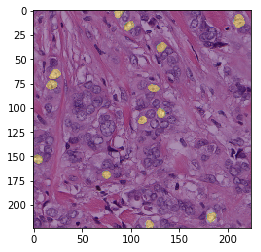

In [23]:
im='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/janowczyk/10X/15902_500_f00111_original.tif_x107_y88.png'
data = np.asarray(Image.open(im))[:,:,0:3]
plt.imshow(data)
plt.imshow(X_train[0], alpha=0.4)

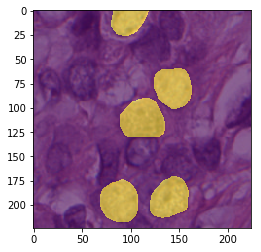

In [44]:
im='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/janowczyk/40X/17558_500_f00037_mask.png_x109_y705.png'
data = np.asarray(Image.open(im))[:,:,0:3]
plt.imshow(data)
plt.imshow(X_train[2], alpha=0.4)

In [43]:
train_patches_fnames[2]

'/home/sebastian/experiments/ScaleExperiments/dataset/patches_miccai18/janowczyk/40X/17558_500_f00037_original.tif_x109_y705.png'

In [16]:
train_patches_fnames[50]

'/home/sebastian/experiments/ScaleExperiments/dataset/patches_miccai18/janowczyk/15X/15902_500_f00111_mask.png_x392_y304.png'

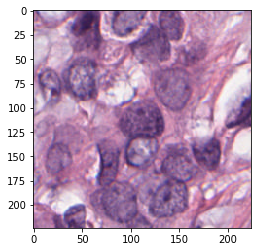

In [35]:
plt.imshow(X_train[2])

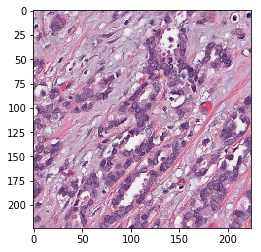

In [39]:
plt.imshow(X_train[-1])

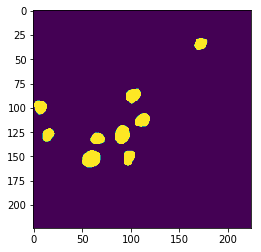

In [14]:
plt.imshow(X_train[50])

In [ ]:
val_patches_f = open('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/validation_patches_fnames.txt','r').readlines()
val_patches_fnames = []
for line in val_patches_f:
    val_patches_fnames.append(line.split()[0])
X_val = []
for im in val_patches_fnames:
    im=im.replace('/home/sebastian/experiments/ScaleExperiments/dataset/', '/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/')
    data = np.asarray(Image.open(im))[:,:,0:3]
    X_val.append(data)
X_val = np.array(X_val)

In [ ]:
test_patches_f = open('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/test_patches_fnames.txt','r')
test_patches_fnames = []
for line in test_patches_f:
    test_patches_fnames.append(line.split()[0])
X_test = []
for im in test_patches_fnames:
    im=im.replace('/home/sebastian/experiments/ScaleExperiments/dataset/', '/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/')
    data = np.asarray(Image.open(im))[:,:,0:3]
    X_test.append(data)
X_test = np.array(X_test)

In [ ]:
im='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/janowczyk/40X/10256_500_f00020_original.tif_x107_y64.png'
data = np.asarray(Image.open(im))[:,:,0:3]
mask='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/janowczyk/40X/10256_500_f00020_mask.png_x107_y64.png'
mask = np.asarray(Image.open(mask))[:,:,0:3]
plt.imshow(data)
#plt.imshow(mask2, alpha=0.5)
plt.imshow(mask, alpha=0.4)



In [ ]:
im='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/janowczyk/10X/10260_500_f00032_original.tif_x40_y208.png'
data = np.asarray(Image.open(im))[:,:,0:3]
mask='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/janowczyk/10X/10260_500_f00032_mask.png_x40_y208.png'
mask = np.asarray(Image.open(mask))[:,:,0:3]
plt.imshow(data)
plt.imshow(mask, alpha=0.4)

In [ ]:
print X_train.shape
print X_val.shape
print X_test.shape
print "DATA LOADED"

In [ ]:
np.save('x_train', X_train)
np.save('x_test', X_test)
np.save('x_val', X_val)

In [ ]:
#Obtaining the average area of nuclei per patch as labels
train_patches_f = open('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/training_patches_fnames.txt','r')
train_masks_fnames = []

for line in train_patches_f:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    mask_fn = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])

    train_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])


Y_train_avgareas = []

for im in train_masks_fnames:
    im=im.replace('/home/sebastian/experiments/ScaleExperiments/dataset/', '/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/')
    orig_img = np.asarray(Image.open(im))[:,:,0]
    thresh = threshold_otsu(orig_img)
    bw = closing(orig_img > thresh, square(2))
    cleared = clear_border(bw)
    label_img = label(cleared)
    props = regionprops(label_img)
    all_props_areas = []
    for region in props:
        # take regions with large enough areas
        if region.area >= 3:
            all_props_areas.append(region.area)
    Y_train_avgareas.append(np.average(all_props_areas))

Y_train_avgareas = np.array(Y_train_avgareas)

In [ ]:
#Obtaining the average area of nuclei per patch as labels
test_patches_f = open('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/test_patches_fnames.txt','r')
test_masks_fnames = []

for line in test_patches_f:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    mask_fn = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])

    test_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])


Y_test_avgareas = []

for im in test_masks_fnames:
    im=im.replace('/home/sebastian/experiments/ScaleExperiments/dataset/', '/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/')
    orig_img = np.asarray(Image.open(im))[:,:,0]
    thresh = threshold_otsu(orig_img)
    bw = closing(orig_img > thresh, square(2))
    cleared = clear_border(bw)
    label_img = label(cleared)
    props = regionprops(label_img)
    all_props_areas = []
    for region in props:
        # take regions with large enough areas
        if region.area >= 3:
            all_props_areas.append(region.area)
    Y_test_avgareas.append(np.average(all_props_areas))

Y_test_avgareas = np.array(Y_test_avgareas)

In [ ]:
#Obtaining the average area of nuclei per patch as labels
val_patches_f = open('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/patches_miccai18/validation_patches_fnames.txt','r')
val_masks_fnames = []

for line in val_patches_f:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    mask_fn = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])

    val_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])


Y_val_avgareas = []

for im in val_masks_fnames:
    im=im.replace('/home/sebastian/experiments/ScaleExperiments/dataset/', '/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/')
    orig_img = np.asarray(Image.open(im))[:,:,0]
    thresh = threshold_otsu(orig_img)
    bw = closing(orig_img > thresh, square(2))
    cleared = clear_border(bw)
    label_img = label(cleared)
    props = regionprops(label_img)
    all_props_areas = []
    for region in props:
        # take regions with large enough areas
        if region.area >= 3:
            all_props_areas.append(region.area)
    Y_val_avgareas.append(np.average(all_props_areas))

Y_val_avgareas = np.array(Y_val_avgareas)

In [ ]:
np.save('y_train_avgareas', Y_train_avgareas)
np.save('y_test_avgareas', Y_test_avgareas)
np.save('y_val_avgareas', Y_val_avgareas)

In [ ]:
Y_train_magn = []
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(train_masks_fnames)):
    magn = train_masks_fnames[i].split('/')[8]
    if magn == '5X':
        magn_5x.append(i)
        Y_train_magn.append(0)
    elif magn == '8X':
        magn_8x.append(i)
        Y_train_magn.append(1)
    elif magn == '10X':
        magn_10x.append(i)
        Y_train_magn.append(2)
    elif magn == '15X':
        magn_15x.append(i)
        Y_train_magn.append(3)
    elif magn == '20X':
        magn_20x.append(i)
        Y_train_magn.append(4)
    elif magn == '30X':
        magn_30x.append(i)
        Y_train_magn.append(5)
    elif magn == '40X':
        magn_40x.append(i)
        Y_train_magn.append(6)
    else:
        print magn
    

In [ ]:
Y_val_magn = []
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(val_masks_fnames)):
    magn = val_masks_fnames[i].split('/')[8]
    if magn == '5X':
        magn_5x.append(i)
        Y_val_magn.append(0)
    elif magn == '8X':
        magn_8x.append(i)
        Y_val_magn.append(1)
    elif magn == '10X':
        magn_10x.append(i)
        Y_val_magn.append(2)
    elif magn == '15X':
        magn_15x.append(i)
        Y_val_magn.append(3)
    elif magn == '20X':
        magn_20x.append(i)
        Y_val_magn.append(4)
    elif magn == '30X':
        magn_30x.append(i)
        Y_val_magn.append(5)
    elif magn == '40X':
        magn_40x.append(i)
        Y_val_magn.append(6)
    else:
        print magn
    

In [ ]:
Y_test_magn = []
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(test_masks_fnames)):
    magn = test_masks_fnames[i].split('/')[8]
    if magn == '5X':
        magn_5x.append(i)
        Y_test_magn.append(0)
    elif magn == '8X':
        magn_8x.append(i)
        Y_test_magn.append(1)
    elif magn == '10X':
        magn_10x.append(i)
        Y_test_magn.append(2)
    elif magn == '15X':
        magn_15x.append(i)
        Y_test_magn.append(3)
    elif magn == '20X':
        magn_20x.append(i)
        Y_test_magn.append(4)
    elif magn == '30X':
        magn_30x.append(i)
        Y_test_magn.append(5)
    elif magn == '40X':
        magn_40x.append(i)
        Y_test_magn.append(6)
    else:
        print magn
    

In [ ]:
all_idx_magn = magn_5x+ magn_8x+ magn_10x+ magn_15x+ magn_20x+ magn_30x+ magn_40x
len(all_idx_magn)

In [ ]:
Y_test_magn

In [ ]:
Y_test_magn = keras.utils.to_categorical(Y_test_magn)

In [ ]:
Y_train_magn = keras.utils.to_categorical(Y_train_magn)
Y_val_magn = keras.utils.to_categorical(Y_val_magn)
np.save('y_train_magn', Y_train_magn)
np.save('y_test_magn', Y_test_magn)
np.save('y_val_magn', Y_val_magn)


In [2]:
Y_train_magn = np.load('y_train_magn.npy')
Y_val_magn = np.load('y_val_magn.npy')
Y_test_magn = np.load('y_test_magn.npy')
X_train = np.load('x_train.npy')
X_val = np.load('x_val.npy')
X_test = np.load('x_test.npy')

In [ ]:
len(test_masks_fnames)

In [ ]:
print Y_train_avgareas.shape
print Y_train_avgareas.sum(), Y_train_avgareas.min(), Y_train_avgareas.max(), Y_train_avgareas.std()
print "====================================================="
print Y_val_avgareas.shape
print Y_val_avgareas.sum(), Y_val_avgareas.min(), Y_val_avgareas.max(), Y_val_avgareas.std()
print "====================================================="
print Y_test_avgareas.shape
print Y_test_avgareas.sum(), Y_test_avgareas.min(), Y_test_avgareas.max(), Y_test_avgareas.std()

In [ ]:
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./_results.baseline.txt', 'w')
fp=open('./_results.pruned.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    inception_scale = keras.applications.InceptionV3(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K

for seed in seeds[:1]:
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    
    baseline_weights = inception_scale.get_weights()
     
    import pdb; pdb.set_trace()

    
    
    inception_pruned = get_baseline_model()
    for l in inception_pruned.layers:
        #print l.name
        if l.name=='mixed8':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    i+=1

In [ ]:
### PROVA MARA ENNESIMA 3.06

nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.txt', 'w')
fp=open('./results.pruned.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    inception_scale = keras.applications.InceptionV3(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K
class_eval=[]
class_eval_pruned=[]
for seed in seeds[:]:
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    
    model_weights=inception_scale.get_weights()
    inception_scale.save_weights('weights_prova_mara')
    np.save('model_weights',model_weights)
    
    inception_pruned = get_baseline_model()
    for l in inception_pruned.layers:
        #print l.name
        if l.name=='mixed8':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    
    model_weights=inception_pruned.get_weights()
    np.save('pruned_model_weights',model_weights)
    
    gt=[21.36937030412282,
    43.153552153335966 ,
    67.30201441627072 ,
    142.3903020801066,
    225.69603728352743,
    489.9801460864018 ,
    913.8187596847976]
    pred_y = inception_scale.predict(X_test)
    pruned_pred_y  = inception_pruned.predict(X_test)
    def get_closest(gt, prediction):
        difference = np.abs(np.asarray(gt) - np.asarray([prediction]*len(gt)))
        return np.argmin(difference)
    
    def get_closest_preds(gt, pred_y):
        return [get_closest(gt, prediction) for prediction in pred_y]

    class_y = get_closest_preds(gt, pred_y)
    import sklearn.metrics
    print 'not_pruned', sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y)
    class_eval.append(sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y))
    np.save('class_y_seed{}'.format(seed), class_y)
    
    class_y = get_closest_preds(gt, pruned_pred_y)
    print 'pruned', sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y)
    np.save('pruned, class_y_seed{}'.format(seed), class_y)
    class_eval_pruned.append(sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y))
    i+=1
np.save('class_eval_pruned', class_eval_pruned)
np.save('class_eval', class_eval)

In [ ]:
keras.backend.clear_session()

In [ ]:
del inception_pruned, inception_scale

In [ ]:
### PROVA MARA ENNESIMA 3.06 -- RESNET

nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.txt', 'w')
fp=open('./results.pruned.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    inception_scale = keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    
    #inception_scale = keras.applications.InceptionV3(include_top=True,weights='imagenet', classes=1000)
    #scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    #inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K
class_eval=[]
class_eval_pruned=[]
for seed in seeds[0:5]:
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    
    model_weights=inception_scale.get_weights()
    #inception_scale.save_weights('weights_prova_mara')
    np.save('resnet_model_weights',model_weights)
    
    inception_pruned = get_baseline_model()

    for l in inception_pruned.layers:
        #print l.name
        if l.name=='add_15':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    
    model_weights=inception_pruned.get_weights()
    np.save('resnet_pruned_model_weights',model_weights)
    
    gt=[21.36937030412282,
    43.153552153335966 ,
    67.30201441627072 ,
    142.3903020801066,
    225.69603728352743,
    489.9801460864018 ,
    913.8187596847976]
    pred_y = inception_scale.predict(X_test)
    pruned_pred_y  = inception_pruned.predict(X_test)
    def get_closest(gt, prediction):
        difference = np.abs(np.asarray(gt) - np.asarray([prediction]*len(gt)))
        return np.argmin(difference)
    
    def get_closest_preds(gt, pred_y):
        return [get_closest(gt, prediction) for prediction in pred_y]

    class_y = get_closest_preds(gt, pred_y)
    import sklearn.metrics
    print 'not_pruned', sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y)
    class_eval.append(sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y))
    np.save('resnet_class_y_seed{}'.format(seed), class_y)
    
    class_y = get_closest_preds(gt, pruned_pred_y)
    print 'pruned', sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y)
    np.save('resnet_pruned, class_y_seed{}'.format(seed), class_y)
    class_eval_pruned.append(sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y))
    i+=1
np.save('class_eval_pruned', class_eval_pruned)
np.save('resnet_class_eval', class_eval)

In [4]:
Y_train_avgareas = np.load('y_train_avgareas.npy')
Y_val_avgareas = np.load('y_val_avgareas.npy')
Y_test_avgareas = np.load('y_test_avgareas.npy')

In [40]:
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.resnet.txt', 'w')
fp=open('./results.pruned.resnet.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    #keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    inception_scale = keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K
class_eval=[]
class_eval_pruned=[]

for seed in seeds[:]:
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #import pdb; pdb.set_trace()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    
    
    #import pdb; pdb.set_trace()
    
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    
    gt=[21.36937030412282,
    43.153552153335966 ,
    67.30201441627072 ,
    142.3903020801066,
    225.69603728352743,
    489.9801460864018 ,
    913.8187596847976]
    def get_closest(gt, prediction):
        difference = np.abs(np.asarray(gt) - np.asarray([prediction]*len(gt)))
        return np.argmin(difference)
    
    def get_closest_preds(gt, pred_y):
        return [get_closest(gt, prediction) for prediction in pred_y]

    
    
    
    pred_y = inception_scale.predict(X_test)
    class_y = get_closest_preds(gt, pred_y)
    import sklearn.metrics
    print 'not_pruned', sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y)
    class_eval.append(sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y))
    np.save('resnet_class_y_seed{}'.format(seed), class_y)
    
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    print seed, 'baseline: ', evaluation_mse
    
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    inception_pruned = get_baseline_model()

    for l in inception_pruned.layers:
        #print l.name
        if l.name=='add_15':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    
    fp.write('{}\n'.format(evaluation_mse))
    print seed, 'pruned: ', evaluation_mse
    
    
    pruned_pred_y  = inception_pruned.predict(X_test)
   
    class_y = get_closest_preds(gt, pruned_pred_y)
    print 'pruned', sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y)
    np.save('resnet_pruned, class_y_seed{}'.format(seed), class_y)
    class_eval_pruned.append(sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1)), class_y))
    i+=1
    
print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)

/home/mara/venv/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/mara/venv/lib/python2.7/site-packages/ipykernel_launcher.py:63: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 45078 samples, validate on 12733 samples
Epoch 1/5
45078/45078 [==============================] - 286s 6ms/step - loss: 108092.8206 - mean_absolute_error: 248.1804 - val_loss: 23382.6650 - val_mean_absolute_error: 105.9006

Epoch 00001: val_loss improved from inf to 23382.66500, saving model to /mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5
Epoch 2/5
45078/45078 [==============================] - 276s 6ms/step - loss: 20308.4834 - mean_absolute_error: 98.5405 - val_loss: 15647.2663 - val_mean_absolute_error: 87.9730

Epoch 00002: val_loss improved from 23382.66500 to 15647.26630, saving model to /mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5
Epoch 3/5
45078/45078 [==============================] - 276s 6ms/step - loss: 13500.5037 - mean_absolute_error: 77.1390 - val_loss: 13014.7241 - val_mean_absolute_error: 67.3056

Epoch 00003: val_loss improved from 15647.26630 to 13014.72412, saving model to /mnt/

/home/mara/venv/lib/python2.7/site-packages/ipykernel_launcher.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/mara/venv/lib/python2.7/site-packages/ipykernel_launcher.py:119: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 45078 samples, validate on 12733 samples
Epoch 1/5
45078/45078 [==============================] - 271s 6ms/step - loss: 112698.2606 - mean_absolute_error: 286.6299 - val_loss: 35803.7840 - val_mean_absolute_error: 167.5488

Epoch 00001: val_loss did not improve from 13014.72412
Epoch 2/5
45078/45078 [==============================] - 264s 6ms/step - loss: 22783.7353 - mean_absolute_error: 115.3792 - val_loss: 27610.6926 - val_mean_absolute_error: 98.6148

Epoch 00002: val_loss did not improve from 13014.72412
Epoch 3/5
45078/45078 [==============================] - 264s 6ms/step - loss: 9706.8398 - mean_absolute_error: 70.0901 - val_loss: 9185.2797 - val_mean_absolute_error: 55.3758

Epoch 00003: val_loss improved from 13014.72412 to 9185.27973, saving model to /mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5
Epoch 4/5
45078/45078 [==============================] - 263s 6ms/step - loss: 5971.4364 - mean_absolute_error: 52.2902 - val_loss: 90

pruned 0.6434613724765436
Train on 45078 samples, validate on 12733 samples
Epoch 1/5
45078/45078 [==============================] - 287s 6ms/step - loss: 106668.4942 - mean_absolute_error: 248.6191 - val_loss: 64272.6864 - val_mean_absolute_error: 189.3658

Epoch 00001: val_loss improved from inf to 64272.68637, saving model to /mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5
Epoch 2/5
45078/45078 [==============================] - 276s 6ms/step - loss: 20541.2665 - mean_absolute_error: 99.4090 - val_loss: 12488.1179 - val_mean_absolute_error: 64.6354

Epoch 00002: val_loss improved from 64272.68637 to 12488.11789, saving model to /mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5
Epoch 3/5
45078/45078 [==============================] - 277s 6ms/step - loss: 11823.7651 - mean_absolute_error: 70.8780 - val_loss: 16416.2360 - val_mean_absolute_error: 77.1334

Epoch 00003: val_loss did not improve from 12488.11789
Epoc

KeyboardInterrupt: 

In [73]:
print np.mean(class_eval[:8]), np.std(class_eval[:8])
print np.mean(np.asarray(class_eval_pruned[:8])), np.std(class_eval_pruned[:8])

0.6098316831789816 0.02626540909412141
0.6232315647045137 0.03379933742229827


In [69]:
class_eval_pruned

[0.6454695397372265,
 0.6427524114492222,
 0.6434613724765436,
 0.6319390773948037,
 0.6342951305455655,
 0.6235905508167932,
 0.5358892106700937,
 0.6284552245458614,
 0.6308575313405209,
 0.6588476250237966,
 0.6620123366813555,
 0.6235905508167932]

In [76]:
np.std(ten_evaluations_pruned[:5])

3.0292121330713306

In [70]:
class_eval

[0.6358252085989899,
 0.5581531275190204,
 0.586997269893165,
 0.6155121081359469,
 0.6053417862689165,
 0.6017734896072665,
 0.6375252377042739,
 0.6375252377042739]

In [45]:
class_eval_pruned

[0.6454695397372265,
 0.6427524114492222,
 0.6434613724765436,
 0.6319390773948037,
 0.6342951305455655,
 0.6235905508167932]

In [60]:
class_eval_pruned=[0.6454695397372265,
 0.6427524114492222,
 0.6434613724765436,
 0.6319390773948037,
 0.6342951305455655,
 0.6235905508167932,
 0.5358892106700937,
  0.6284552245458614,
  0.6308575313405209,
  0.6588476250237966,
  0.6620123366813555,
  0.6235905508167932]

In [13]:
pruned_pred_y  = inception_pruned.predict(X_test)

In [52]:
class_eval_pruned.append([0.5358892106700937,
 0.6284552245458614,
 0.6308575313405209,
 0.6588476250237966,
 0.6620123366813555,
 0.6235905508167932])

In [65]:
class_eval.append(0.6375252377042739)

In [ ]:
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.resnet.txt', 'w')
fp=open('./results.pruned.resnet.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    #keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    inception_scale = keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K

for seed in seeds:
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #import pdb; pdb.set_trace()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    print seed, 'baseline: ', evaluation_mse
    
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    inception_pruned = get_baseline_model()

    for l in inception_pruned.layers:
        #print l.name
        if l.name=='add_15':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    print seed, 'pruned: ', evaluation_mse
    i+=1
    
print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)

In [ ]:
class_eval

In [ ]:
np.mean(class_eval), np.std(class_eval)

In [ ]:
np.mean(class_eval_pruned), np.std(class_eval_pruned)

In [ ]:
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(X_train)):
    magn = Y_train_magn[i]
    if magn == 0:
        magn_5x.append(Y_train_avgareas[i])
        #Y_test_magn.append(0)
    elif magn == 1:
        magn_8x.append(Y_train_avgareas[i])
        #Y_test_magn.append(1)
    elif magn == 2:
        magn_10x.append(Y_train_avgareas[i])
        #Y_test_magn.append(2)
    elif magn == 3:
        magn_15x.append(Y_train_avgareas[i])
        #Y_test_magn.append(3)
    elif magn == 4:
        magn_20x.append(Y_train_avgareas[i])
        #Y_test_magn.append(4)
    elif magn == 5:
        magn_30x.append(Y_train_avgareas[i])
        #Y_test_magn.append(5)
    elif magn == 6:
        magn_40x.append(Y_train_avgareas[i])
        #Y_test_magn.append(6)
    else:
        print magn

In [ ]:
print np.mean(magn_5x), np.mean(magn_8x), np.mean(magn_10x), np.mean(magn_15x),  np.mean(magn_20x), np.mean(magn_30x),np.mean(magn_40x),   

In [ ]:
len(X_train)

In [ ]:
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(X_test)):
    magn = np.argmax(Y_test_magn[i])
    if magn == 0:
        magn_5x.append(Y_test_avgareas[i])
        #Y_test_magn.append(0)
    elif magn == 1:
        magn_8x.append(Y_test_avgareas[i])
        #Y_test_magn.append(1)
    elif magn == 2:
        magn_10x.append(Y_test_avgareas[i])
        #Y_test_magn.append(2)
    elif magn == 3:
        magn_15x.append(Y_test_avgareas[i])
        #Y_test_magn.append(3)
    elif magn == 4:
        magn_20x.append(Y_test_avgareas[i])
        #Y_test_magn.append(4)
    elif magn == 5:
        magn_30x.append(Y_test_avgareas[i])
        #Y_test_magn.append(5)
    elif magn == 6:
        magn_40x.append(Y_test_avgareas[i])
        #Y_test_magn.append(6)
    else:
        print magn

In [ ]:
print np.mean(magn_5x), np.mean(magn_8x), np.mean(magn_10x), np.mean(magn_15x),  np.mean(magn_20x), np.mean(magn_30x),np.mean(magn_40x),   

In [ ]:
Y_train_magn = []
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(train_masks_fnames)):
    magn = train_masks_fnames[i].split('/')[8]
    if magn == '5X':
        magn_5x.append(i)
        Y_train_magn.append(0)
    elif magn == '8X':
        magn_8x.append(i)
        Y_train_magn.append(1)
    elif magn == '10X':
        magn_10x.append(i)
        Y_train_magn.append(2)
    elif magn == '15X':
        magn_15x.append(i)
        Y_train_magn.append(3)
    elif magn == '20X':
        magn_20x.append(i)
        Y_train_magn.append(4)
    elif magn == '30X':
        magn_30x.append(i)
        Y_train_magn.append(5)
    elif magn == '40X':
        magn_40x.append(i)
        Y_train_magn.append(6)
    else:
        print magn
    

In [ ]:
def get_area_regression_model(weights):
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    inception_scale = keras.applications.InceptionV3(include_top=False, classes=1)
    #inception_scale.set_weights(weights)
    #import pdb; pdb.set_trace()
    gap_layer = keras.layers.GlobalAveragePooling2D()(inception_scale.output)
    scale_regression_layer = keras.layers.Dense(1)(gap_layer)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    inception_scale.set_weights(weights)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.SGD(lr=1e-3),
              metrics=['accuracy'])
    
    return inception_scale

In [ ]:
weights=np.load('model_weights.npy')
model = get_area_regression_model(weights)
pred_y = model.predict(X_test)
# Now you compute the distance from pred_y and the mean of the avg areas 
#for the images of each magnification class

In [ ]:
gt=[np.mean(magn_5x), 
    np.mean(magn_8x), 
    np.mean(magn_10x), 
    np.mean(magn_15x),  
    np.mean(magn_20x), 
    np.mean(magn_30x),
    np.mean(magn_40x)]

In [ ]:
gt=[27.26346156096971,
 44.99085108575298,
 68.14755427843059,
 143.6875355239101,
 222.3488223698118,
 470.24914351998416,
 889.8286503425016]
gt=[21.36937030412282,
    43.153552153335966 ,
    67.30201441627072 ,
    142.3903020801066,
    225.69603728352743,
    489.9801460864018 ,
    913.8187596847976]
"""
gt=[19,
 30,
 68.14755427843059,
 143.6875355239101,
 222.3488223698118,
 470.24914351998416,
 889.8286503425016]"""

In [ ]:
def get_closest(gt, prediction):
    difference = np.abs(np.asarray(gt) - np.asarray([prediction]*len(gt)))
    return np.argmin(difference)
    
def get_closest_preds(gt, pred_y):
    return [get_closest(gt, prediction) for prediction in pred_y]



In [ ]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


In [ ]:
class_y = get_closest_preds(gt, pred_y.T[0])
import sklearn.metrics
print sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn[:], axis=1)), class_y[:])

In [ ]:
class_y = get_closest_preds(gt, smooth(pred_y.T[0]))
import sklearn.metrics
print sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn[:11000], axis=1)), class_y[:11000])

In [ ]:
print sklearn.metrics.confusion_matrix(np.asarray(np.argmax(Y_test_magn, axis=1))[:5594], class_y[:5594])

In [ ]:
pruned_class_y = get_closest_preds(gt,smooth(pruned_pred_y.T[0]))
print sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1))[:5594], pruned_class_y[:5594])
print sklearn.metrics.confusion_matrix(np.asarray(np.argmax(Y_test_magn, axis=1))[:5594], pruned_class_y[:5594])

In [ ]:
sklearn.metrics.mean_absolute_error(Y_test_avgareas[:], pruned_pred_y[:])

In [ ]:
sklearn.metrics.mean_absolute_error(pred_y[:], Y_test_avgareas[:])

In [ ]:
np.mean(np.abs(Y_test_avgareas[:]-pred_y.T[0]))

In [ ]:
np.mean(np.abs(Y_test_avgareas[:]-pruned_pred_y.T[0]))

In [ ]:
inception_pruned.evaluate(X_test, Y_test_avgareas)

In [ ]:
inception_scale.evaluate(X_test, Y_test_avgareas)

In [ ]:
inception_scale.metrics

In [ ]:
data= Y_test_avgareas[:5594]#, np.argmax(Y_test_magn, axis=1)

In [ ]:
np.asarray(data).T.shape
data=np.asarray(data).T

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
km = KMeans(n_clusters=7).fit(data.reshape(-1,1))

In [ ]:
km.cluster_centers_

In [ ]:
labels = [2,6,0,4,1,5,3]

In [ ]:
closest= km.predict(pred_y.T[0].reshape(-1,1))

In [ ]:
p=[labels[i] for i in closest]
plt.plot(p)
plt.plot(np.argmax(Y_test_magn, axis=1))

In [ ]:
sklearn.metrics.cohen_kappa_score(np.asarray(np.argmax(Y_test_magn, axis=1))[:5594], p[:5594])

In [ ]:
inputs = np.float64(X_train[0])
#inputs = models.standardPreprocess(inputs)
get_layer_output = keras.backend.function([inception_scale.layers[0].input],
                          [inception_scale.get_layer('avg_pool').output])

In [ ]:
all_feats = []
for i in range(len(X_train)):
    inputs = np.float64(X_train[i])
    feats = get_layer_output([np.expand_dims(inputs, axis=0)])
    all_feats.append(feats)

In [ ]:
X_train_features = np.asarray(all_feats).reshape(len(X_train),2048)

In [ ]:
np.save('x_train_features', X_train_features)

In [ ]:
all_feats = []
for i in range(len(X_val)):
    inputs = np.float64(X_val[i])
    feats = get_layer_output([np.expand_dims(inputs, axis=0)])
    all_feats.append(feats)

In [ ]:
X_val_features = np.asarray(all_feats).reshape(len(X_val),2048)
np.save('x_val_features', X_val_features)

all_feats = []
for i in range(len(X_test)):
    inputs = np.float64(X_test[i])
    feats = get_layer_output([np.expand_dims(inputs, axis=0)])
    all_feats.append(feats)
X_test_features = np.asarray(all_feats).reshape(len(X_test),2048)
np.save('x_test_features', X_test_features)

In [ ]:
X_train_features = np.load('x_train_features.npy')
X_val_features = np.load('x_val_features.npy')
X_test_features = np.load('x_test_features.npy')

In [ ]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(2048,)))#, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(7, input_shape=(2048,), activation='softmax'))
model = keras.models.Model(input=model.input, output=model.output)


In [ ]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=1e-2, decay=1e-6) ,
                  metrics=['accuracy'])

In [ ]:
model.fit(X_train_features, Y_train_magn, epochs=5, shuffle=True,
                         validation_data=(X_val_features,Y_val_magn), batch_size=32,  verbose=1)


In [ ]:
import sklearn.metrics
prediction = model.predict(X_test_features)
print sklearn.metrics.cohen_kappa_score(Y_test_magn, np.argmax(prediction,axis=1))

In [ ]:
inputs = np.float64(X_train[0])
#inputs = models.standardPreprocess(inputs)
get_layer_output = keras.backend.function([inception_pruned.layers[0].input],
                          [inception_pruned.get_layer('global_average_pooling2d_2').output])
all_feats = []
for i in range(len(X_train)):
    inputs = np.float64(X_train[i])
    feats = get_layer_output([np.expand_dims(inputs, axis=0)])
    all_feats.append(feats)
X_train_features = np.asarray(all_feats).reshape(len(X_train),1280)
all_feats = []
for i in range(len(X_val)):
    inputs = np.float64(X_val[i])
    feats = get_layer_output([np.expand_dims(inputs, axis=0)])
    all_feats.append(feats)
np.save('pruned_x_train_features', X_train_features)
X_val_features = np.asarray(all_feats).reshape(len(X_val),1280)
np.save('pruned_x_val_features', X_val_features)

all_feats = []
for i in range(len(X_test)):
    inputs = np.float64(X_test[i])
    feats = get_layer_output([np.expand_dims(inputs, axis=0)])
    all_feats.append(feats)
X_test_features = np.asarray(all_feats).reshape(len(X_test),1280)
np.save('pruned_x_test_features', X_test_features)

In [ ]:
X_train_features= np.load('pruned_x_train_features.npy')
X_val_features= np.load('pruned_x_val_features.npy')
X_test_features = np.load('pruned_x_test_features.npy')

In [ ]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(1280,)))#, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(7, activation='softmax'))
classification_model = keras.models.Model(input=model.input, output=model.output)

classification_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=1e-2, decay=1e-6) ,
                  metrics=['accuracy'])

In [ ]:
classification_model.fit(X_train_features, Y_train_magn, epochs=5, shuffle=True,
                         validation_data=(X_val_features,Y_val_magn), batch_size=32,  verbose=1)


In [ ]:
import sklearn.metrics
prediction = classification_model.predict(X_test_features)
print sklearn.metrics.cohen_kappa_score(Y_test_magn, np.argmax(prediction,axis=1))

In [ ]:
X_train_features[:,0].shape
#np.argmax(Y_train_magn, axis=1)

In [ ]:
X_train_features

In [ ]:
plt.scatter(X_train_features[:,0], np.argmax(Y_train_magn, axis=1))

In [ ]:
model_weights=np.load('./model_weights.npy', allow_pickle=True)
classifier_model = get_scale_classification_model(model_weights)

In [ ]:
classifier_model.summary()

In [ ]:
preds = classifier_model.predict(X_test)

In [ ]:
classifier_model.compile( loss='categorical_crossentropy',
                          optimizer= keras.optimizers.SGD(lr=1e-2),
                          metrics=['accuracy'])
classifier_model.fit(X_train, Y_train_magn, nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1)
evaluation_loss, evaluation_mse = classifier_model.evaluate(X_test,Y_test_magn)

In [ ]:
""" /mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5
"""

In [ ]:
print ten_evaluations_baseline, ten_evaluations_pruned

In [ ]:
print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)

In [ ]:
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)

In [ ]:
plt.imshow(X_val[10])

In [ ]:
keras.backend.clear_session()

In [ ]:
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.resnet.txt', 'w')
fp=open('./results.pruned.resnet.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    #keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    inception_scale = keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K

for seed in seeds:
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #import pdb; pdb.set_trace()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    print seed, 'baseline: ', evaluation_mse
    
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    inception_pruned = get_baseline_model()

    for l in inception_pruned.layers:
        #print l.name
        if l.name=='add_15':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    print seed, 'pruned: ', evaluation_mse
    i+=1
    
print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)

In [ ]:
##MAGNIFICATION EASY 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.resnet.txt', 'w')
fp=open('./results.pruned.resnet.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    #keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    inception_scale = keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K

for seed in seeds[:1]:
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #import pdb; pdb.set_trace()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    new_classification_layer = keras.layers.Dense(7)(inception_scale.layers[-2].output)
    inception_scale_classification = keras.models.Model(input=inception_scale.input, output=new_classification_layer)
    inception_scale_classification.compile(loss='categorical_crossentropy',
          optimizer= Adam(1e-4) ,
          metrics=['accuracy'])
    for l in layers[-2]:
        l.trainable=False
    inception_scale_classification.fit(X_train,Y_train_magn,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1)
    testy = np.argmax(Y_test_magn, axis=1)
    yhat_classes= np.argmax(y_test_predicted_baseline, axis=1)
    # kappa
    kappa = cohen_kappa_score(testy, yhat_classes)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    #auc = roc_auc_score(testy, yhat_probs)
    #print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(testy, yhat_classes)
    print(matrix)

In [ ]:
#inception_scale_classification.fit(X_train,Y_train_magn,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1)
y_test_predicted_baseline=inception_scale_classification.predict(X_test)    
testy = np.argmax(Y_test_magn, axis=1)
yhat_classes= np.argmax(y_test_predicted_baseline, axis=1)
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#auc = roc_auc_score(testy, yhat_probs)
#print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

In [ ]:
#y_test_predicted_baseline=inception_scale_classification.predict(X_test)
f.write('{}\n'.format(evaluation_mse))
print seed, 'baseline: ', evaluation_mse

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision = precision_recall_fscore_support(testy, yhat_classes)
#print('Precision: %f' % precision)
#

In [ ]:
precision

In [ ]:
testy = np.argmax(Y_test_magn, axis=1)
yhat_classes= np.argmax(y_test_predicted_baseline, axis=1)
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#auc = roc_auc_score(testy, yhat_probs)
#print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

In [ ]:
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
 

In [ ]:
#new_classification_layer = keras.layers.Dense(7)(inception_scale.layers[-2].output)
#inception_scale_classification = keras.models.Model(input=inception_scale.input, output=new_classification_layer)
#inception_scale_classification.compile(loss='categorical_crossentropy',
#          optimizer=adam_opt ,
#          metrics=['accuracy'])
#inception_scale_classification.fit(X_train,Y_train_magn,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1,callbacks=[checkpointer])
y_test_predicted_baseline=inception_scale_classification.predict(X_test)
f.write('{}\n'.format(evaluation_mse))
print seed, 'baseline: ', evaluation_mse

keras.backend.clear_session()
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
random.seed(seed)
tf.set_random_seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
inception_pruned = get_baseline_model()

for l in inception_pruned.layers:
    #print l.name
    if l.name=='add_15':
        stop_layer = l 
scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)

if clip_norm:
    adam_opt = Adam(lr,clipnorm=1)
else:
    adam_opt = Adam(lr)
inception_pruned.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
Y_test_predicted_pruned = inception_pruned.predict(X_test)
ten_evaluations_pruned[i]=evaluation_mse  
classification_layer = keras.layers.Dense(7)(inception_pruned.layers[-2].output)
inception_pruned_classification = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
inception_pruned_classification.compile(loss='categorical_crossentropy',
          optimizer=adam_opt ,
          metrics=['accuracy'])
inception_pruned_classification.fit(X_train,Y_train_magn,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1,callbacks=[checkpointer])
y_test_predicted_pruned=inception_pruned_classification.predict(X_test)
fp.write('{}\n'.format(evaluation_mse))
print seed, 'pruned: ', evaluation_mse
i+=1

print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)


In [ ]:
new_classification_layer = keras.layers.Dense(7)(inception_scale.layers[-2].output)
inception_scale_classification = keras.models.Model(input=inception_scale.input, output=new_classification_layer)


In [ ]:
plt.plot(np.sort(np.ravel(Y_test_predicted_pruned)))
plt.plot(np.sort([Y_test_magn[i] * 100 for i in range(len(Y_test_magn))]))

In [ ]:
plt.plot((np.ravel(Y_test_predicted_pruned[:2000])/np.max(Y_test_predicted_pruned)))
plt.plot(np.asarray(Y_test_magn, dtype=np.float)[:2000]/np.max(Y_test_magn))

In [ ]:
Y_test_magn/np.max(Y_test_magn)

In [ ]:
np.histogram(Y_test_predicted_pruned)[1]

In [ ]:
#(Testing Magnification)
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.resnet.txt', 'w')
fp=open('./results.pruned.resnet.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    #keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    inception_scale = keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(7)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='categorical_crossentropy',
              optimizer=adam_opt ,
              metrics=['accuracy'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K

for seed in seeds:
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #import pdb; pdb.set_trace()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_magn,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_magn)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    print seed, 'baseline: ', evaluation_mse
    
    keras.backend.clear_session()
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    inception_pruned = get_baseline_model()

    for l in inception_pruned.layers:
        #print l.name
        if l.name=='add_15':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(7)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='categorical_crossentropy',
                  optimizer=adam_opt ,
                  metrics=['accuracy'])
    inception_pruned.fit(X_train,Y_train_magn,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_magn), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_magn)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    print seed, 'pruned: ', evaluation_mse
    i+=1
    
print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)

In [ ]:
nb_filters = 32
nb_epoch = 5
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)
lr = 0.0001
clip_norm = False 
f=open('./results.baseline.densenet.txt', 'w')
fp=open('./results.pruned.densenet.txt', 'w')

def get_baseline_model():
    # Setting the parameters and building the baseline model
    lr = 0.0001
    clip_norm = False 
    #model_scale = baseline_model(lr,clip_norm)
    keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    inception_scale = keras.applications.densenet.DenseNet121(include_top=True,weights='imagenet', classes=1000)
    scale_regression_layer = keras.layers.Dense(1)(inception_scale.layers[-2].output)
    inception_scale = keras.models.Model(input=inception_scale.input, output=scale_regression_layer)
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    inception_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return inception_scale

# Provide the same seed and keyword arguments to the fit and evaluate methods
ten_evaluations_baseline = np.zeros(10)
ten_evaluations_pruned = np.zeros(10)
seeds = [1001, 1003, 1005, 1006, 1008, 2009, 2020, 994, 747, 1456]
i=0
import os
import random
import tensorflow as tf
from keras import backend as K

for seed in seeds:
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    inception_scale = get_baseline_model()
    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    #os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
    checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_weights.hdf5', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    inception_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_scale.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_baseline[i] = evaluation_mse
    f.write('{}\n'.format(evaluation_mse))
    """
    inception_pruned = get_baseline_model()
    for l in inception_pruned.layers:
        #print l.name
        if l.name=='mixed8':
            stop_layer = l 
    scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
    scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
    inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)
    
    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)
    inception_pruned.compile(loss='mean_squared_error',
                  optimizer=adam_opt ,
                  metrics=['mae'])
    inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])
    evaluation_loss, evaluation_mse = inception_pruned.evaluate(X_test,Y_test_avgareas)
    ten_evaluations_pruned[i]=evaluation_mse  
    fp.write('{}\n'.format(evaluation_mse))
    i+=1
    """
print np.mean(ten_evaluations_baseline),  np.std(ten_evaluations_baseline)
print np.mean(ten_evaluations_pruned),  np.std(ten_evaluations_pruned)

In [ ]:
import pdb; pdb.set_trace()

In [ ]:
X

#Defining the CallBacks for tensorboard visualization and for earlystopping of the model
os.mkdir('/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models')
checkpointer = ModelCheckpoint(filepath='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/best_shallownet_weights.hdf5', verbose=1, save_best_only=True)
tb_callback = TensorBoard(log_dir='/mnt/nas2/results/IntermediateResults/Mara/thomas_extension/models/logsTensorBoard/', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [ ]:
del inception_pruned
inception_pruned = keras.applications.InceptionV3(include_top=True,weights='imagenet', classes=1000)

In [ ]:
for l in inception_pruned.layers:
    print l.name
    if l.name=='mixed8':
        stop_layer = l 
scale_regression_layer = keras.layers.GlobalAveragePooling2D()(stop_layer.output)
scale_regression_layer = keras.layers.Dense(1)(scale_regression_layer)
inception_pruned = keras.models.Model(input=inception_pruned.input, output=scale_regression_layer)

In [ ]:
if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
else:
    adam_opt = Adam(lr)
inception_pruned.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])

In [ ]:
inception_pruned.summary()

In [ ]:
inception_pruned.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer])


In [ ]:
inception_pruned.evaluate(X_test,Y_test_avgareas)

In [ ]:
inception_scale.evaluate(X_test,Y_test_avgareas)